# Introduction



Libraries used

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Loading and Treating Dataset

### Description
This study uses the patent dataset provided by Emer (Emer,2025), available in https://zenodo.org/records/15545361. The dataset was selected because it comprises approximately 63,000 United States patents related to climate-oriented Artificial Intelligence (AI) technologies. It was constructed using data from the PatentsView database of the United States Patent and Trademark Office (USPTO), filtered according to the Cooperative Patent Classification (CPC) system. Specifically, CPC classes Y02 and Y04S were used to identify environmentally relevant technologies, while the Artificial Intelligence Patent Dataset (AIPD) was used to identify AI-related inventions.

The resulting dataset contains patent abstracts spanning the period from 1976 to 2023. After filtering, a topic modeling procedure based on the BERTopic framework was applied to cluster patents into sixteen distinct technology domains. In addition, a column denoted real-value was incorporated, representing a market-implied private economic value proxy derived from the methodology proposed by (Kogan,2017).

### Loading dataset

In [117]:
root_path = '../dataset/'
path_1 = f'{root_path}Green_AI_Patents.csv'

df_green_AI = pd.read_csv(path_1)

### Checking dataset

In [118]:
df_green_AI.dtypes

patent_id              int64
cpc_subclass          object
patent_date           object
patent_title          object
assignee              object
country               object
forward_citations      int64
tech_domain          float64
real_value           float64
dtype: object

Preparing dataset

In [119]:
# columns used
id_col='patent_id'
year_col = 'year'
domain_id_col = 'tech_domain'
pat_date_col = 'patent_date'
forward_citation_col = 'forward_citations'
real_value_col = 'real_value'

Following the reference table provided by authors, below are the corresponding names of each domain:

In [120]:
domain_labels = {
	0:"Data Processing & Memory Management",
	1:"Microgrid & Distributed Energy Systems",
	2:"Vehicle Control & Autonomous Powertrains",
	3:"Irrigation & Agricultural Water Mgmt",
	4:"Photovoltaic & Electrochemical Devices",
	5:"Clinical Microbiome & Therapeutics",
	6:"Combustion Engine Control",
	7:"Battery Charging & Management",
	8:"HVAC & Thermal Regulation",
	9:"Lighting & Illumination Systems",
	10:"Exhaust & Emission Treatment",
	11:"Wind Turbine & Rotor Control",
	12:"Aircraft Wing Aerodynamics & Control",
	13:"Meteorological Radar & Weather Forecasting",
	14:"Fuel Cell Systems & Electrodes",
	15:"Turbine Airfoils & Cooling"
}


### Removing null values

In [121]:
# Checking for null values
df_green_AI.isna().sum()

patent_id                0
cpc_subclass             0
patent_date              0
patent_title             0
assignee              3847
country               4171
forward_citations        0
tech_domain            989
real_value           37020
dtype: int64

In [122]:
df_green_AI = df_green_AI.dropna(subset=[domain_id_col])

### Removing outliers

In [123]:
# Removing outliers detected by BERTopic
df_green_AI = df_green_AI[df_green_AI[domain_id_col]!=-1]

### Formating columns

In [124]:
df_green_AI[id_col] = df_green_AI[id_col].astype(str)
df_green_AI[year_col] = pd.to_datetime(df_green_AI[pat_date_col]).dt.year
df_green_AI[domain_id_col] = df_green_AI[domain_id_col].astype(int)

### Removing duplicates

In [125]:
df_green_AI.duplicated().sum()

np.int64(0)

Sorting domain to alphabetic order

In [126]:
domains = sorted(df_green_AI[domain_id_col].unique())
domains_sorted = sorted(domain_labels.keys(), key=lambda d: domain_labels[d])

# Methodology

## Mapping Maturity

Defining the three descriptors with smoothed curves based on Slocum (2001) recommendations

In [127]:
def smooth(series):
    return series.rolling(3, min_periods=1).mean()

Descriptor A: Patent Activity

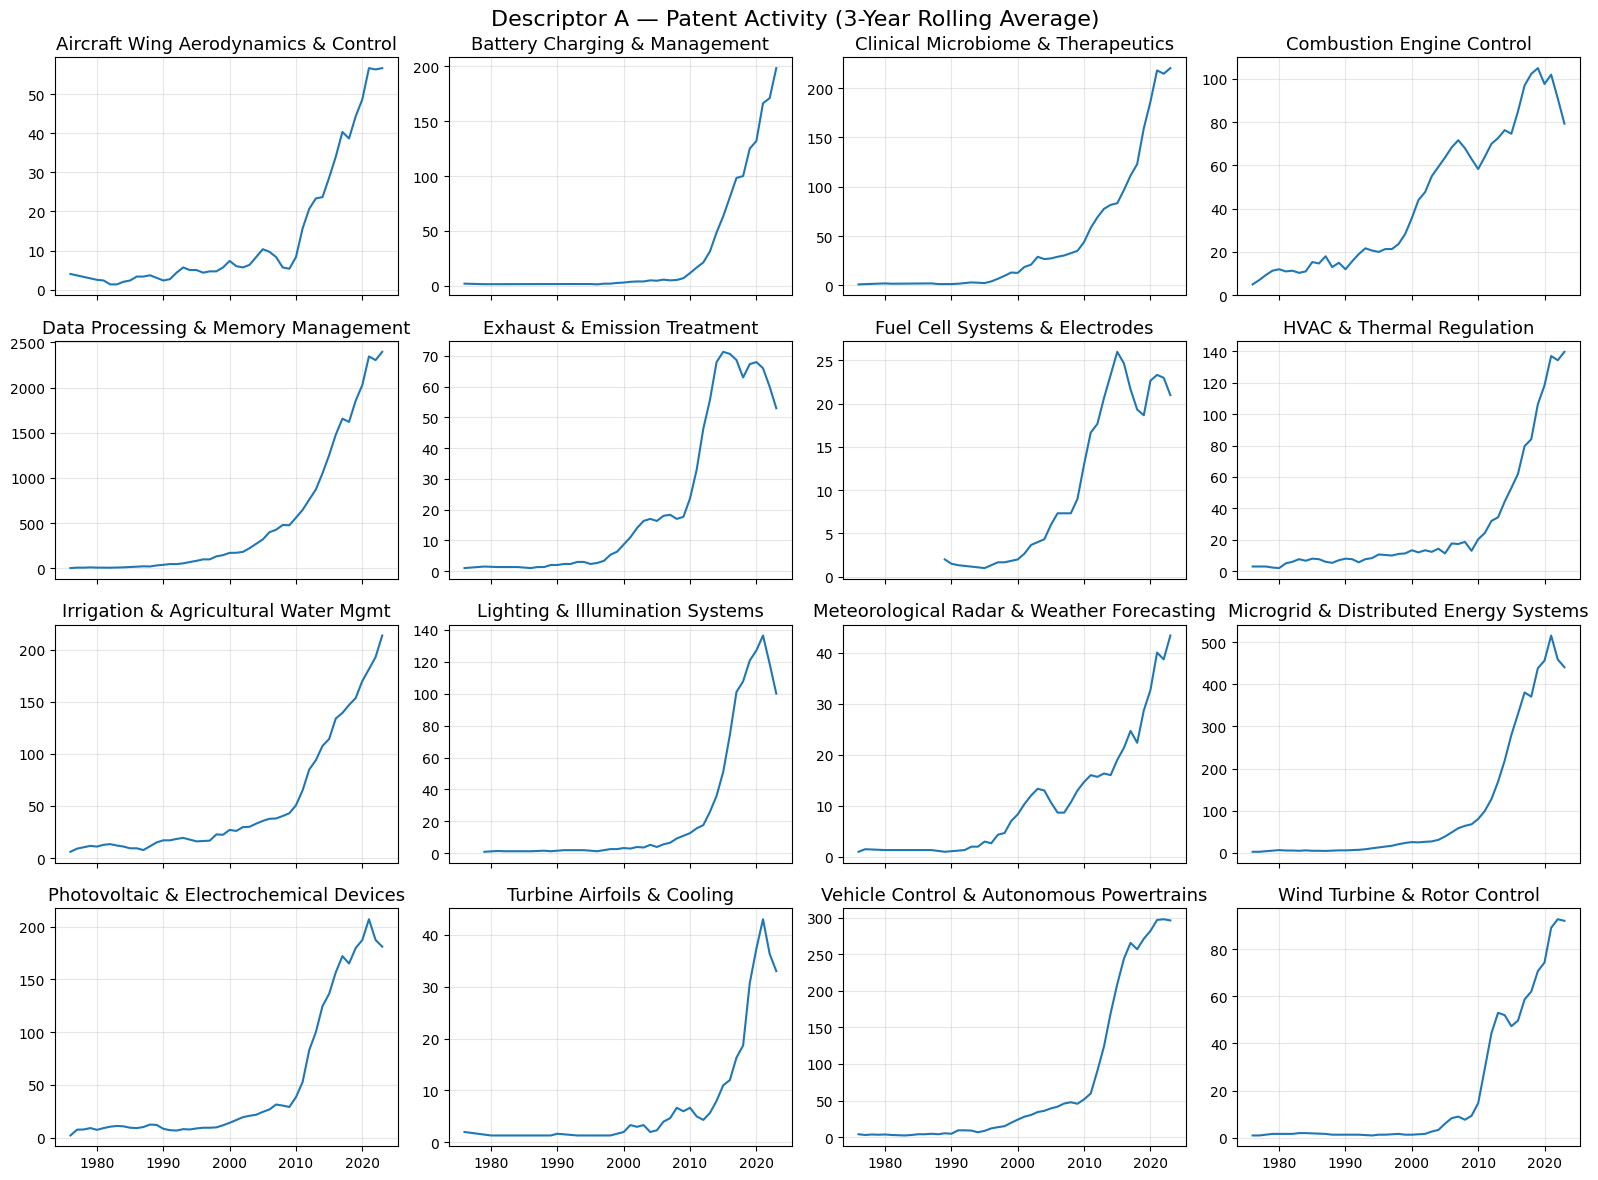

In [128]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains_sorted):
    sub = df_green_AI[df_green_AI[domain_id_col]==d]
    A = smooth(sub.groupby(year_col).size())

    ax.plot(A.index, A.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=13)
    ax.grid(alpha=0.3)

fig.suptitle("Descriptor A — Patent Activity (3-Year Rolling Average)", fontsize=16)
plt.tight_layout()
plt.savefig("../results/maturity_analysis-descriptor-A.png", dpi=300, bbox_inches='tight')

plt.show()

Descriptor B: Innovation Level proxied by Forward Citations

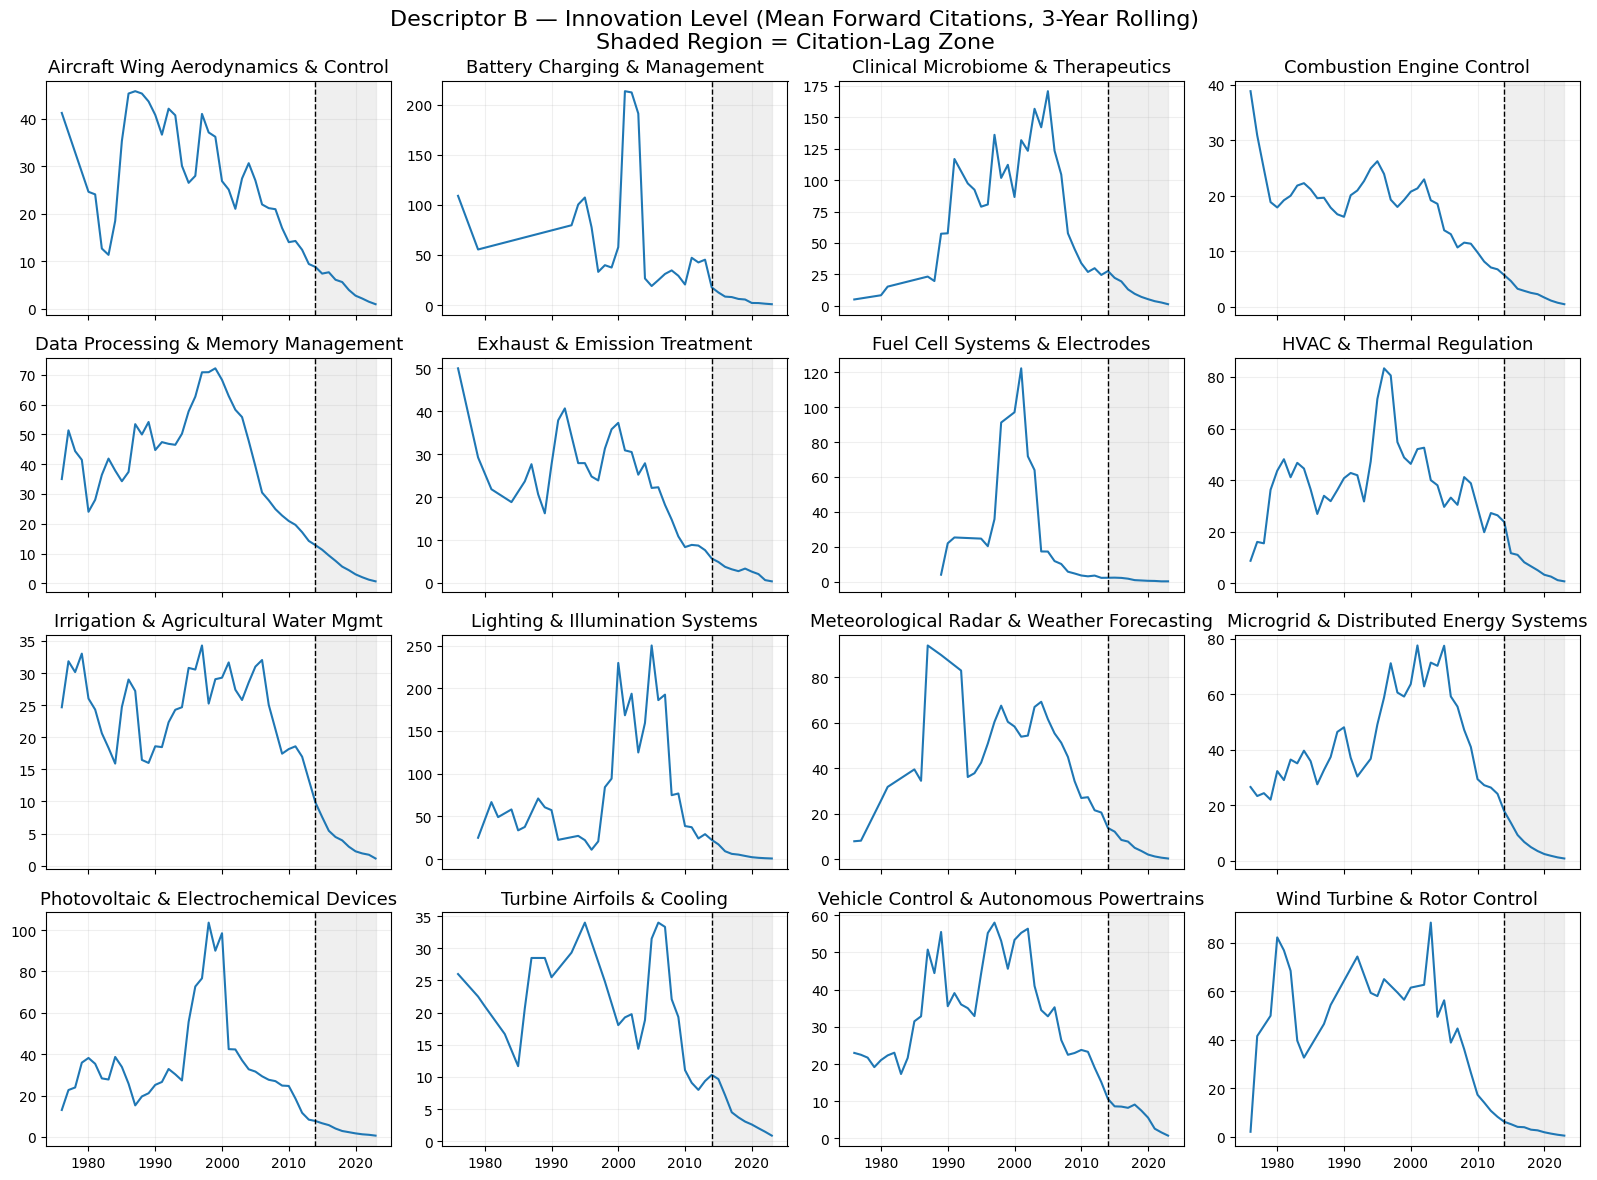

In [129]:
lag_start_year = 2014
lag_color = 'lightgray'
lag_alpha = 0.35

fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains_sorted):
    sub = df_green_AI[df_green_AI["tech_domain"]==d]
    B = smooth(sub.groupby(year_col)[forward_citation_col].mean())

    ax.plot(B.index, B.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=13)
    
    ax.axvspan(lag_start_year, B.index.max(),color=lag_color, alpha=lag_alpha)
    ax.axvline(lag_start_year, color='black', linestyle='--', linewidth=1)

    ax.grid(True, alpha=0.2)

fig.suptitle("Descriptor B — Innovation Level (Mean Forward Citations, 3-Year Rolling)\nShaded Region = Citation-Lag Zone", fontsize=16)
plt.tight_layout()
plt.savefig("../results/maturity_analysis-descriptor-B.png", dpi=300, bbox_inches='tight')
plt.show()


Descriptor C: Technical Performance proxied by Kogan market value 

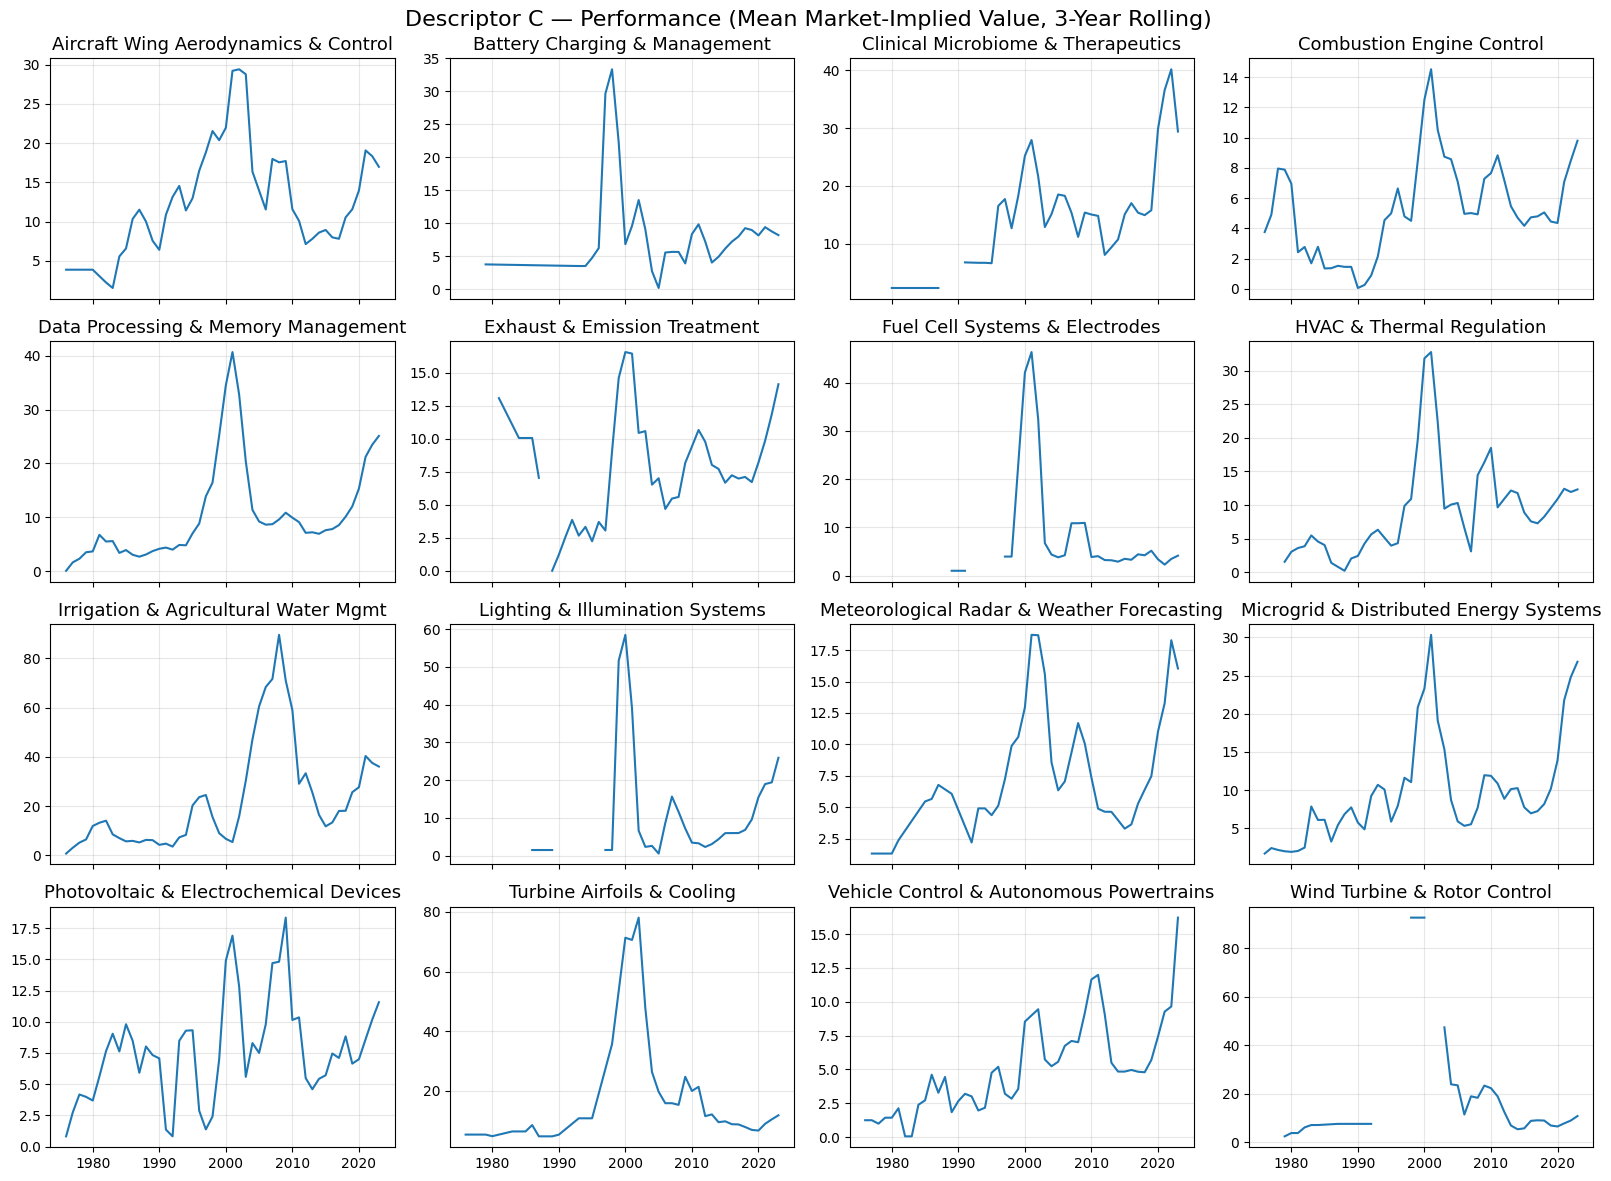

In [130]:
# Descriptor C — Performance (Market Value)
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains_sorted):
    sub = df_green_AI[df_green_AI[domain_id_col]==d]
    C = smooth(sub.groupby(year_col)[real_value_col].mean())

    ax.plot(C.index, C.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=13)
    ax.grid(alpha=0.3)

fig.suptitle("Descriptor C — Performance (Mean Market-Implied Value, 3-Year Rolling)", fontsize=16)
plt.tight_layout()
plt.savefig("../results/maturity_analysis-descriptor-C.png", dpi=300, bbox_inches='tight')
plt.show()



| Domain                                     | Patent Activity   | Innovation | Performance              | Maturity     |
| ------------------------------------------ | ----------------- | ---------- | ------------------------ | ------------ |
| Aircraft Wing Aerodynamics & Control       | High and stable   | Exhausted  | Stable                   | **Maturity** |
| Battery Charging & Management              | Rising            | Cooling    | Stable                   | **Maturity** |
| Clinical Microbiome & Therapeutics         | Rising            | Cooling    | Strengthening & volatile | **Growth**   |
| Combustion Engine Control                  | Decreasing        | Exhausted  | Declining                | **Decline**  |
| Data Processing & Memory Management        | High and stable   | Cooling    | Stable                   | **Maturity** |
| Exhaust & Emission Treatment               | Decreasing        | Exhausted  | Episodic / compressing   | **Decline**  |
| Fuel Cell Systems & Electrodes             | Low               | Unstable   | Speculative              | **Infancy**  |
| HVAC & Thermal Regulation                  | Rising            | Low        | Stable                   | **Maturity** |
| Irrigation & Agricultural Water Mgmt       | Rising            | Peak       | Strengthening            | **Growth**   |
| Lighting & Illumination Systems            | Decreasing        | Exhausted  | Declining                | **Decline**  |
| Meteorological Radar & Weather Forecasting | Rising            | Peak       | Episodic                 | **Growth**   |
| Microgrid & Distributed Energy Systems     | High and unstable | Exhausted  | Compressing / episodic   | **Decline**  |
| Photovoltaic & Electrochemical Devices     | High and unstable | Low        | Stable                   | **Maturity** |
| Turbine Airfoils & Cooling                 | Decreasing        | Exhausted  | Declining                | **Decline**  |
| Vehicle Control & Autonomous Powertrains   | High and stable   | Peak       | Strengthening & volatile | **Growth**   |
| Wind Turbine & Rotor Control               | Rising            | Peak       | Strengthening            | **Growth**   |


| Patent Activity (Inventive Effort) | Innovation / Novelty Dynamics | Economic / Performance Signal | Lifecycle Stage |
| ---------------------------------- | ----------------------------- | ----------------------------- | --------------- |
| Low                                | Unstable / exploratory        | Speculative or weak           | **Infancy**     |
| Rising or high                     | Peak or cooling               | Strengthening or volatile     | **Growth**      |
| High or rising                     | Low or exhausted              | Stable                        | **Maturity**    |
| Decreasing or unstable             | Exhausted                     | Declining or compressing      | **Decline**     |


## Computing Innovation Pace

Mapping maturity classification to each domain

In [131]:
maturity = {
	12:"Maturity",       
	7:"Maturity",       
	5:"Growth",
	6:"Decline",
	0:"Maturity",
	10:"Decline",
	14:"Infancy",
	8:"Maturity",
	3:"Growth",
	9:"Decline",
	13:"Growth",
	1:"Decline",
	4:"Maturity",
	15:"Decline",
	2:"Growth",
	11:"Growth",
}

In [132]:
# Smoothing window
ROLLING = 3  

Computing knowledge stock log-growth

In [133]:
def compute_log_growth(series, window):
    K = series.cumsum()
    K_s = K.rolling(window=window, min_periods=min(2, window)).mean()
    return np.log(K_s)

def compute_log_growth_rate(logK):
    return logK.diff().dropna().mean()

Computing knowledge log-growth doubling time 

In [134]:
def compute_doubling_time(g_rate):
	if g_rate <= 0:
		doubling_time = np.inf
	else:
		doubling_time = np.log(2) / g_rate

	return doubling_time

Computing innovation acceleration

In [135]:
def compute_acceleration(yearly_counts, logK):
    # first derivative: pace
    pace = logK.diff()

    # second derivative: acceleration
    accel = pace.diff()

    # return average acceleration (structural signal)
    return accel.dropna().mean()

Computing all year rates

In [136]:
def compute_year_rates(df_green_AI):
	records = []

	for domain, g in df_green_AI.groupby(domain_id_col):
		yearly = g.groupby(year_col).size().sort_index()

		if len(yearly) < 5:
			continue
		
		logK = compute_log_growth(yearly, ROLLING)
		g_rate = compute_log_growth_rate(logK)
		doubling_time = compute_doubling_time(g_rate)
		a = compute_acceleration(yearly, logK)

		records.append({
			"tech_domain": domain,
			"logK": logK,
			"growth_rate": g_rate,
			"doubling_time_years": doubling_time,
			"acceleration": a
		})

	year_rates = pd.DataFrame(records)
	return year_rates

In [137]:
d_df = compute_year_rates(df_green_AI)

Classifying each rate

In [138]:
def classify_doubling_time(dt):
    if dt <= 10:
        return "Fast (climate-aligned)"
    elif dt <= 15:
        return "Marginal"
    elif dt <= 25:
        return "Slow"
    else:
        return "Insufficient"
    
def classify_acceleration(a, eps=1e-3):
	if a > eps:
		return "Accelerating"
	elif a < -eps:
		return "Decelerating"
	else:
		return "Stable"
	

In [139]:
d_df["pace_class"] = d_df["doubling_time_years"].apply(classify_doubling_time)
d_df["decel_class"] = d_df["acceleration"].apply(classify_acceleration)
d_df = d_df.sort_values("doubling_time_years")

Adding labels

In [140]:
d_df["maturity_class"] = d_df[domain_id_col].map(maturity)
d_df["domain"] = d_df[domain_id_col].map(domain_labels)

Styling plot

In [141]:
maturity_colors = {
    "Infancy": "#9ecae1", 
    "Growth": "#4bb86a",  
    "Maturity": "#f4c430",
    "Decline": "#d55c4b" 
}


decel_markers = {
    "Accelerating": "▲",
    "Stable": "●",
    "Decelerating": "▼"
}

Ploting results

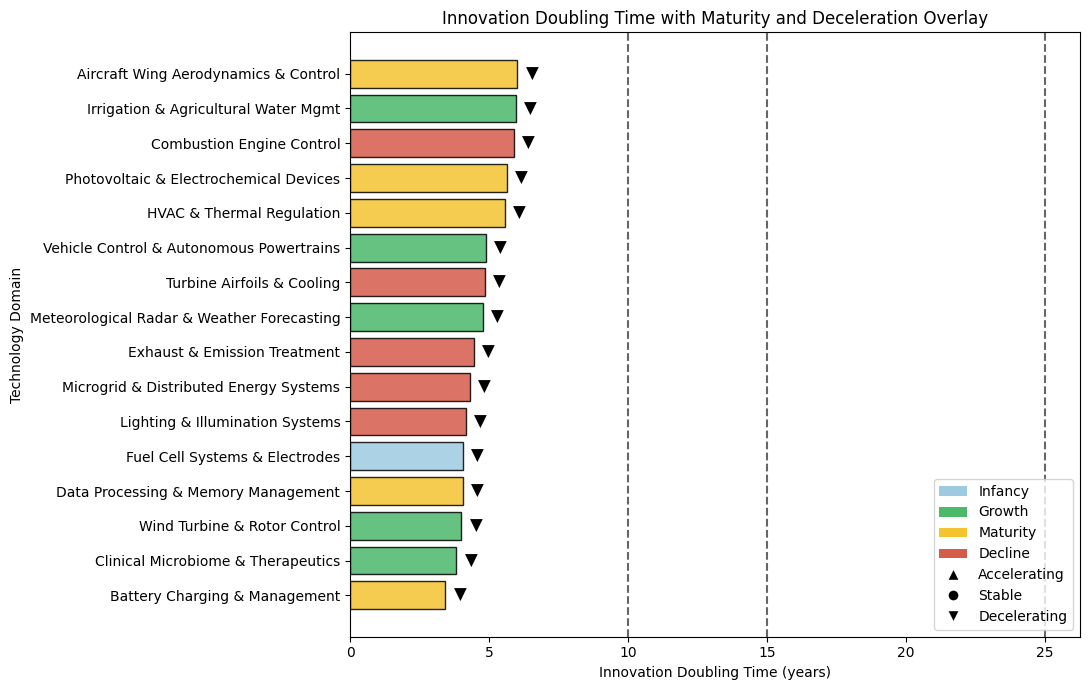

In [142]:
fig, ax = plt.subplots(figsize=(11, 7))

# Doubling Time 
bars = ax.barh(
    d_df["domain"],
    d_df["doubling_time_years"],
    color=d_df["maturity_class"].map(maturity_colors),
    edgecolor="black",
    alpha=0.85
)

# Climate horizons
for h in [10, 15, 25]:
    ax.axvline(h, linestyle="--", color="black", alpha=0.6)

# Overlay deceleration markers
for i, row in enumerate(d_df.itertuples()):
    ax.text(
        row.doubling_time_years + 0.3,
        i,
        decel_markers[row.decel_class],
        va="center",
        ha="left",
        fontsize=12
    )

# Labels
ax.set_xlabel("Innovation Doubling Time (years)")
ax.set_ylabel("Technology Domain")
ax.set_title("Innovation Doubling Time with Maturity and Deceleration Overlay")

# Legends
maturity_legend = [
    Patch(facecolor=c, label=k) for k, c in maturity_colors.items()
]

decel_legend = [
    Line2D([0], [0], marker="^", color="w", label="Accelerating", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker="o", color="w", label="Stable", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker="v", color="w", label="Decelerating", markerfacecolor="black", markersize=8)
]

ax.legend(
    handles=maturity_legend + decel_legend,
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.savefig("../results/pace-rank.png", dpi=300, bbox_inches='tight')
plt.show()


## Forecasting

In [143]:
def forecast_innovation_baseline(df, horizon=15, domain_col="tech_domain", logK_col="logK", g_col="growth_rate", a_col="acceleration"):
    records = []

    for _, row in df.iterrows():
        domain = row[domain_col]
        logK_t = row[logK_col]
        g_t = row[g_col]
        a_bar = row[a_col]
        
        for h in range(1, horizon + 1):
            g_th = g_t + h * a_bar
            
            # Skip invalid continuation (pace <= 0)
            if g_th <= 0:
                continue
            
            logK_th = logK_t + np.sum([g_t + i * a_bar for i in range(1, h + 1)])
            dt_th = np.log(2) / g_th
            
            records.append({
                "domain": domain,
                "horizon": h,
                "innovation_pace": g_th,
                "log_knowledge_stock": logK_th,
                "doubling_time": dt_th
            })
    
    return pd.DataFrame(records)


In [146]:
forecast_df = forecast_innovation_baseline(d_df,horizon=20)
forecast_df['domain_name'] = forecast_df['domain'].map(domain_labels)

forecast_df.head()

,domain,horizon,innovation_pace,log_knowledge_stock,doubling_time,domain_name
0,7,1,0.198200,year 1976 NaN 1979 1.114490 1993 ...,3.497218,Battery Charging & Management
1,7,2,0.194008,year 1976 NaN 1979 1.308498 1993 ...,3.572780,Battery Charging & Management
2,7,3,0.189816,year 1976 NaN 1979 1.498314 1993 ...,3.651679,Battery Charging & Management
3,7,4,0.185624,year 1976 NaN 1979 1.683938 1993 ...,3.734142,Battery Charging & Management
4,7,5,0.181432,year 1976 NaN 1979 1.865371 1993 ...,3.820416,Battery Charging & Management


In [148]:
DT_THRESHOLD = 7.0

threshold_crossings = (
    forecast_df
    .query("doubling_time >= @DT_THRESHOLD")
    .groupby("domain_name", as_index=False)
    .agg(first_exceed_horizon=("horizon", "min"),
         dt_at_crossing=("doubling_time", "first"))
)

threshold_crossings


,domain_name,first_exceed_horizon,dt_at_crossing
0,Aircraft Wing Aerodynamics & Control,9,7.019657
1,Clinical Microbiome & Therapeutics,18,7.357435
2,Combustion Engine Control,2,7.148210
3,Data Processing & Memory Management,12,7.322105
4,Exhaust & Emission Treatment,10,7.244078
5,Fuel Cell Systems & Electrodes,17,7.129123
6,HVAC & Thermal Regulation,7,7.197745
7,Irrigation & Agricultural Water Mgmt,3,7.384673
8,Lighting & Illumination Systems,13,7.053872
9,Meteorological Radar & Weather Forecasting,9,7.120979


In [149]:
df_domains = d_df.copy()

In [159]:
def forecast_baseline(df, horizon=20):
    records = []

    for _, r in df.iterrows():
        for h in range(1, horizon + 1):
            g_th = r["growth_rate"] + h * r["acceleration"]
            if g_th <= 0:
                break

            logK_th = r["logK"] + np.sum(
                [r["growth_rate"] + i * r["acceleration"] for i in range(1, h + 1)]
            )

            records.append({
                "domain": r["domain"],
                "horizon": h,
                "innovation_pace": g_th,
                "doubling_time": np.log(2) / g_th,
                "log_knowledge_stock": logK_th,
                "scenario": "baseline"
            })

    return pd.DataFrame(records)


In [ ]:
def compute_reference_envelope(df_forecast, df_domains):
    reference_domains = df_domains.query("fos_role == 'reference'")["domain"]

    envelope = (
        df_forecast
        .query("domain in @reference_domains")
        .groupby("horizon")["innovation_pace"]
        .median()
        .reset_index(name="reference_median_pace")
    )

    return envelope


In [161]:
def fos_scenario_evaluation(
    baseline_forecast,
    reference_envelope
):
    fos_df = baseline_forecast.merge(
        reference_envelope,
        on="horizon",
        how="left"
    )

    fos_df["relative_pace_gap"] = (
        fos_df["innovation_pace"]
        - fos_df["reference_median_pace"]
    )

    fos_df["fos_state"] = np.where(
        fos_df["relative_pace_gap"] >= 0,
        "search-aligned",
        "search-constrained"
    )

    fos_df["scenario"] = "fos_scenario"

    return fos_df


In [ ]:
FOS_DOMAIN_ROLES = {
    # FOS TARGET DOMAINS
    "Battery Charging & Management": "target",
    "Fuel Cell Systems & Electrodes": "target",
    "Wind Turbine & Rotor Control": "target",
    "Data Processing & Memory Management": "target",
    "Clinical Microbiome & Therapeutics": "target",

    # REFERENCE DOMAINS (SOLUTION DONORS)
    "Aircraft Wing Aerodynamics & Control": "reference",
    "Combustion Engine Control": "reference",
    "Photovoltaic & Electrochemical Devices": "reference",
    "HVAC & Thermal Regulation": "reference",
    "Irrigation & Agricultural Water Management": "reference",
    "Meteorological Radar & Weather Forecasting": "reference",

    # EXCLUDED DOMAINS
    "Carbon Capture & Storage": "excluded",
    "Hydrogen Production Technologies": "excluded",
    "Smart Grid Communication Systems": "excluded",
    "Biofuel Processing & Conversion": "excluded",
    "Green Building Materials": "excluded"
}


In [165]:
df_domains['fos_role'] = df_domains['domain'].map(FOS_DOMAIN_ROLES)

In [167]:
baseline_df = forecast_baseline(df_domains, horizon=20)

reference_env = compute_reference_envelope(
    baseline_df,
    df_domains
)

fos_scenario_df = fos_scenario_evaluation(
    baseline_df,
    reference_env
)

forecast_all = pd.concat(
    [baseline_df, fos_scenario_df],
    ignore_index=True
)


In [168]:
def compute_scenario_ranks(df):
    df = df.copy()
    df["pace_rank"] = (
        df
        .groupby(["scenario", "horizon"])["innovation_pace"]
        .rank(ascending=False, method="dense")
    )
    return df

ranked_scenarios = compute_scenario_ranks(forecast_all)


In [169]:
fos_alignment = (
    fos_scenario_df
    .merge(
        df_domains[["domain", "fos_role"]],
        on="domain"
    )
    .query("fos_role == 'target'")
    .groupby("domain")
    .agg(
        aligned_horizons=("fos_state", lambda x: (x == "search-aligned").sum())
    )
)

fos_alignment


,aligned_horizons
domain,
Battery Charging & Management,20
Clinical Microbiome & Therapeutics,20
Data Processing & Memory Management,19
Fuel Cell Systems & Electrodes,20
Wind Turbine & Rotor Control,5
